# The 2-halo Term

In this notebook we show how to compute the 2-halo term for the gas and dark matter density profiles.

In [45]:
# preamble
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from init_halo_model import bM, cM_relation, cosmo, hmc, hmd  # halo model

import glasz

We define the halo model using `pyccl`

In [46]:
# CMASS PARAMETERS
z_lens = 0.55  # Mean z for CMASS
a_sf = 1 / (1 + z_lens)

# constituent fractions
fb = cosmo["Omega_b"] / cosmo["Omega_m"]  # Baryon fraction
fc = cosmo["Omega_c"] / cosmo["Omega_m"]  # CDM fraction

# arrays for k, a, and r
k_arr = np.geomspace(1e-4, 1e4, 128)  # Wavenumber array
a_arr = np.linspace(0.1, 1, 16)  # Scale factor array
r_arr = np.geomspace(1e-2, 1e2, 100)  # Distance array

We then compute the matter-matter correlation function (2-halo term)

In [47]:
xi_mm_2h = glasz.profiles.calc_xi_mm_2h(
    cosmo, hmd, cM_relation, hmc, k_arr, a_arr, r_arr, a_sf
)

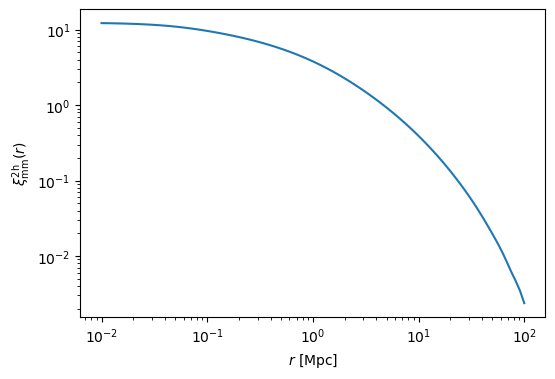

In [48]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(r_arr, xi_mm_2h(r_arr))
ax.set_xlabel(r"$r$ [Mpc]")
ax.set_ylabel(r"$\xi^{\rm 2h}_{\rm mm}(r)$")
plt.show()

With this correlation function, we can then input this into our profile functions. More on this in the `profiles` section of the documentation.

In [49]:
# Halo Mass
M_halo = 3e13

# 2-halo Amplitude
A_2h = 1.0

# GNFW Parameters
alpha = 1.0
beta = 3.0
gamma = 0.2
x_c = 0.5

Rb = 10 * hmd.get_radius(cosmo, M_halo, a_sf)

# COMPUTE GNFW AMPLITUDE
prof_nfw = ccl.halos.HaloProfileNFW(
    mass_def=hmd, concentration=cM_relation, truncated=False, fourier_analytic=True
)

prof_baryons = glasz.profiles.HaloProfileGNFW(
    hmd,
    rho0=1.0,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    x_c=x_c,
)

prof_baryons.normalize(cosmo, Rb, M_halo, a_sf, prof_nfw)


# COMPUTE 3D DENSITY PROFILES
def rho_2h(r):
    return (
        xi_mm_2h(r)
        * bM(cosmo, M_halo, a_sf)
        * ccl.rho_x(cosmo, a_sf, "matter", is_comoving=True)
        * A_2h
    )


prof_baryons.rho_2h = rho_2h  # add 2-halo term to baryon profile

prof_matter = glasz.profiles.MatterProfile(
    mass_def=hmd, concentration=cM_relation, rho_2h=rho_2h
)

We end up with profiles for the baryons, dark matter, and total matter all at once. These can be decomposed into their 1-halo and 2-halo terms respectively. 

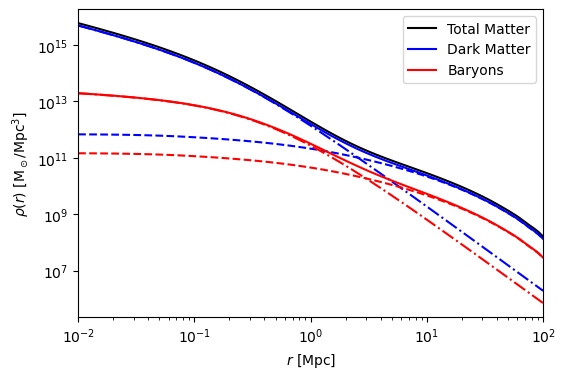

In [50]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(
    r_arr,
    prof_matter.real(cosmo, r_arr, M_halo, a_sf),
    color="black",
    label="Total Matter",
)  # full

ax.loglog(
    r_arr,
    (prof_nfw.real(cosmo, r_arr, M_halo, a_sf) + rho_2h(r_arr)) * fc,
    color="blue",
    ls="-",
    label="Dark Matter",
)  # full
ax.loglog(
    r_arr, prof_nfw.real(cosmo, r_arr, M_halo, a_sf) * fc, color="blue", ls="-."
)  # 1-halo
ax.loglog(r_arr, rho_2h(r_arr) * fc, color="blue", ls="--")  # 2-halo

ax.loglog(
    r_arr,
    prof_baryons.real(cosmo, r_arr, M_halo, a_sf) * fb,
    color="red",
    label="Baryons",
)  # full
ax.loglog(
    r_arr,
    (prof_baryons.real(cosmo, r_arr, M_halo, a_sf) - rho_2h(r_arr)) * fb,
    color="red",
    ls="-.",
)  # 1-halo
ax.loglog(r_arr, rho_2h(r_arr) * fb, color="red", ls="--")  # 2-halo

ax.set_xlabel(r"$r$ [Mpc]")
ax.set_ylabel(r"$\rho(r)$ [M$_\odot$/Mpc$^3$]")
ax.set_xlim(1e-2, 1e2)
ax.legend()
plt.show()